In [1]:
#This notebook is for testing plotting of TriPIPS data from the real-time script's netCDF file dumps
%matplotlib notebook
import os
import pandas as pd
import xarray as xr
import numpy as np
import time
import matplotlib.pyplot as plt
from pyPIPS import thermolib as thermo
from pyPIPS import timemodule as tm
from datetime import datetime, timedelta
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import pyPIPS.plotmodule as pm
from pyPIPS.PIPS import avg_diameter, avg_fall_bins, max_diameter, \
    min_diameter, min_fall_bins, diameter_edges, fall_bins_edges
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Function definitions. 

In [3]:
# Set up directories reading the data and plotting
# base_output_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/TriPIPS/webdata/'
base_input_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/TriPIPS/'
netcdf_input_dir = os.path.join(base_input_dir, 'netcdf_web')
plot_output_dir = os.path.join(base_input_dir, 'plots')

if not os.path.exists(plot_output_dir):
    os.makedirs(plot_output_dir)


In [34]:
# Set up the date and times to read and plot
# For now just read in a one-hour chunk of data from a single file. 
datetime_stamp = '20220505210000'
ND_file = 'ND_{}.nc'.format(datetime_stamp)
ND_path = os.path.join(netcdf_input_dir, ND_file)
ND_ds = xr.load_dataset(ND_path)

conv_file = 'onesec_{}.nc'.format(datetime_stamp)
conv_path = os.path.join(netcdf_input_dir, conv_file)
conv_ds = xr.load_dataset(conv_path)


In [24]:
# Set up dictionaries to control plotting parameters

dateformat = '%H:%M'

# Temperature and dewpoint
temp_dewp_ax_params = {
    'majorxlocator': dates.MinuteLocator(byminute=[0, 15, 30, 45], interval=1), 
    'majorxformatter': dates.DateFormatter(dateformat),
    'minorxlocator': dates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], interval=1),
    'axeslimits': [None, (-5., 35.)],
    'axeslabels': ['Time (H:M) UTC', r'Temperature ($^{\circ}$C)']
}

# Wind speed and direction
windspd_ax_params = {
    'majorxlocator': dates.MinuteLocator(byminute=[0, 15, 30, 45], interval=1), 
    'majorxformatter': dates.DateFormatter(dateformat),
    'minorxlocator': dates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], interval=1),
    'axeslimits': [None, [0.0, 25.0]],
    'axeslabels': ['Time (H:M) UTC', r'wind speed (m s$^{-1}$)']
}

winddir_ax_params = {
    'majorylocator': ticker.MultipleLocator(45.),
    'axeslimits': [None, [0.0, 360.0]],
    'axeslabels': [None, r'Wind direction ($^{\circ}$C)']
}

pressure_ax_params = {
    'majorylocator': ticker.MultipleLocator(5.),
    'axeslimits': [None, [940., 980.]],
    'axeslabels': [None, r'Pressure (hPa)']
}



# Number concentration
log_ND_params = {
    'type': 'pcolor', 
    'vlimits': [-1.0, 3.5],
    'clabel': r'log[N ($m^{-3} mm^{-1}$)]'
}

log_ND_ax_params = {
    'majorxlocator': dates.MinuteLocator(byminute=[0, 15, 30, 45], interval=1), 
    'majorxformatter': dates.DateFormatter(dateformat),
    'minorxlocator': dates.MinuteLocator(byminute=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], interval=1),
    'axeslimits': [None, [0.0, 3.0]],
    'majorylocator': ticker.MultipleLocator(base=0.25),
    'axeslabels': [None, 'D (mm)']
}

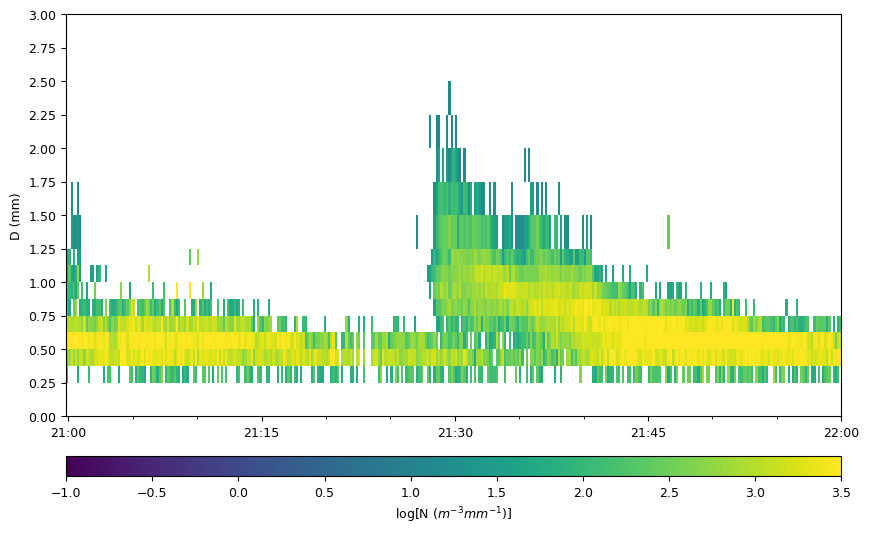

In [25]:
# Quick DSD meteogram
fig, ax = plt.subplots(figsize=(10, 6))
plottimes_tmp = ND_ds['time'].to_index().to_pydatetime()
# Prepend an additional at the beginning of the array so that pcolor sees this as the
# edges of the DSD intervals.
plottimes = np.insert(plottimes_tmp, 0, plottimes_tmp[0] - timedelta(seconds=10))
plottimes = [plottimes]

ND_da = ND_ds['spectrum']

ND_arr = ND_da.values.T
logND_arr = np.ma.log10(ND_arr)
fields_to_plot = [logND_arr]
field_parameters = [log_ND_params]
ax = pm.plotmeteogram(ax, plottimes, fields_to_plot, field_parameters,
                      yvals=[diameter_edges] * len(fields_to_plot))
ax, = pm.set_meteogram_axes([ax], [log_ND_ax_params])

In [32]:
print(min_diameter)
print(max_diameter - min_diameter)

[ 0.     0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125
  1.25   1.5    1.75   2.     2.25   2.5    3.     3.5    4.     4.5
  5.     6.     7.     8.     9.    10.    12.    14.    16.    18.
 20.    23.   ]
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.25  0.25
 0.25  0.25  0.25  0.5   0.5   0.5   0.5   0.5   1.    1.    1.    1.
 1.    2.    2.    2.    2.    2.    3.    3.   ]


Text(0, 0.5, 'N(D) $(m^{-4})$')

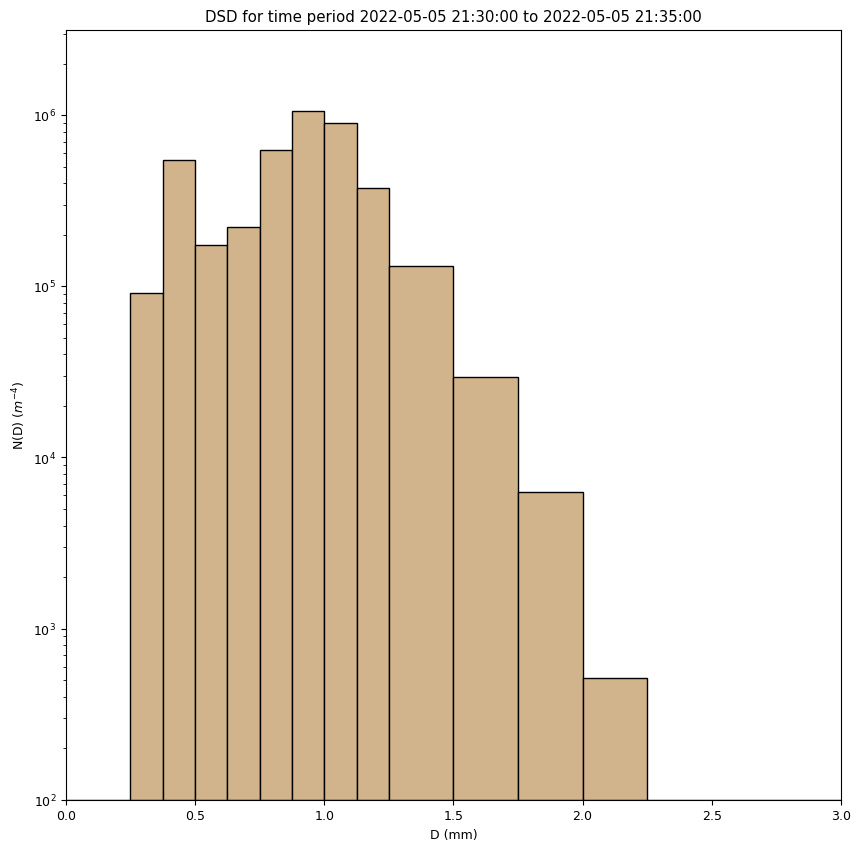

In [30]:
# Quick DSD plot
fig_dsd, ax_dsd = plt.subplots(figsize=(10, 10))
time_to_plot = '20220505213500'
datetime_to_plot = datetime.strptime(time_to_plot, tm.timefmt3)
datetime_minus_5min = datetime_to_plot - timedelta(minutes=5)
ND_avg_da = ND_da.sel(time=slice(datetime_minus_5min, datetime_to_plot)).mean(dim='time')

ND_avg = ND_avg_da.values
ax_dsd.set_title('DSD for time period {0} to {1}'.format(
    datetime_minus_5min.strftime(tm.timefmt2),
    datetime_to_plot.strftime(tm.timefmt2)))
ax_dsd.bar(min_diameter, ND_avg * 1000.0, max_diameter - min_diameter, 10.**2., align='edge',
           log=True, color='tan', edgecolor='k')
ax_dsd.set_xlim(0.0, 3.0)
ax_dsd.set_ylim(10.**2., 10.**6.5)
ax_dsd.set_xlabel('D (mm)')
ax_dsd.set_ylabel(r'N(D) $(m^{-4})$')

<xarray.Dataset>
Dimensions:        (index: 3601)
Coordinates:
  * index          (index) datetime64[ns] 2022-05-05T21:00:00 ... 2022-05-05T...
Data variables: (12/20)
    Record         (index) float64 8.119e+06 8.119e+06 ... 8.123e+06 8.123e+06
    BattV          (index) float64 12.89 12.89 12.89 12.89 ... 12.89 12.89 12.89
    PTemp_C        (index) float64 14.95 14.95 14.95 14.95 ... 14.95 14.95 14.95
    WindDir        (index) float64 106.0 104.0 90.0 72.0 ... 86.0 86.0 95.0 97.0
    WS_ms          (index) float64 2.29 1.77 2.43 3.32 ... 1.48 1.41 1.21 1.24
    WSDiag         (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...             ...
    GPSSpd         (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    GPSDir         (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    GPSDate        (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    GPSMagVar      (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    GPSAlt  

/Users/dawson29/Projects/pyPIPS/pyPIPS/plotmodule.py:1052: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(xval, zval, ls=linestyle, lw=linewidth, marker=marker, color=color,


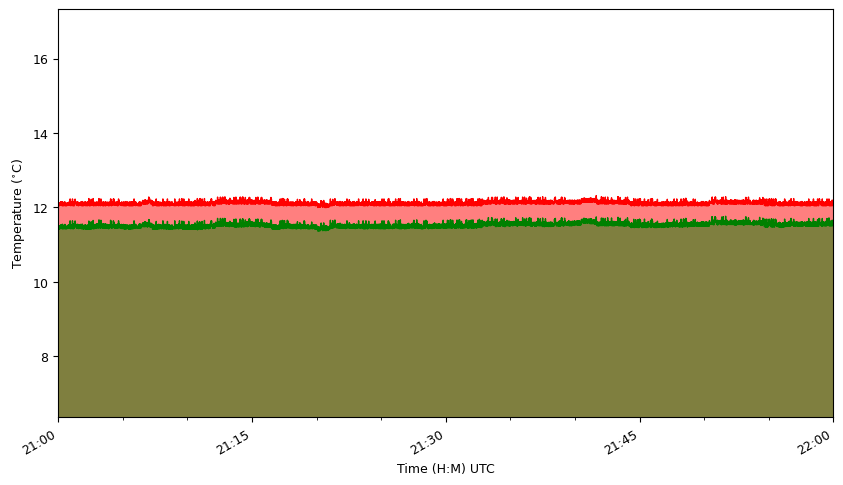

In [38]:
fig_t_td, ax_t_td = plt.subplots(figsize=(10, 6))
plottimes_onesec = [conv_ds['index'].to_index().to_pydatetime()]
# Temperature and Dewpoint
Tmin = np.nanmin(conv_ds['Dewpoint'].values)
Tmax = np.nanmax(conv_ds['SlowTemp'].values)
fields_to_plot_onesec = [conv_ds['SlowTemp'].values, conv_ds['Dewpoint'].values]
temp_params = pm.temp_params.copy()
dewpoint_params = pm.dewpoint_params.copy()
temp_params['plotmin'] = Tmin - 5.0
dewpoint_params['plotmin'] = Tmin - 5.0
field_parameters_onesec = [temp_params, dewpoint_params]
ax_t_td = pm.plotmeteogram(
    ax_t_td,
    plottimes_onesec,
    fields_to_plot_onesec,
    field_parameters_onesec)
temp_dewp_ax_params['axeslimits'] = [[plottimes_onesec[0][0], plottimes_onesec[0][-1]],
                                     [Tmin - 5.0, Tmax + 5.0]]
ax_t_td, = pm.set_meteogram_axes([ax_t_td], [temp_dewp_ax_params])

In [ ]:
#%%time
#for i in range(numiter):
while True:
    ax.clear()
    ax_vd.clear()
    ax_t_td.clear()
    ax_windspd.clear()
    ax_winddir.clear()
    ax_pressure.clear()
    onesec_new_df = scrape_tripips_onesec_data(url_onesec, numrecords=numrecords_append_onesec)
    onesec_new_df['Dewpoint'] = thermo.calTdfromRH(onesec_new_df['Pressure'] * 100., onesec_new_df['SlowTemp'] + 273.15, 
                                     onesec_new_df['RH'] / 100.) - 273.15
    # Append new data onto onesec_df
    onesec_df = onesec_df.append(onesec_new_df)
    # Drop duplicate timestamps
    onesec_df = onesec_df[~onesec_df.index.duplicated(keep='first')]
    # Drop records older than desired interval
    last_timestamp_onesec = onesec_df.index[-1]
    oldest_timestamp_onesec = last_timestamp_onesec-keep_data_for_ts
    onesec_df = onesec_df.loc[oldest_timestamp_onesec:]
    # Dump onesec dataframe to netCDF file (via xarray)
    netcdf_filename = 'onesec_{}_{}.nc'.format(oldest_timestamp_onesec.strftime('%Y%m%d%H%M%S'), 
                                               last_timestamp_onesec.strftime('%Y%m%d%H%M%S' ))
    netcdf_path = os.path.join(netcdf_output_dir, netcdf_filename)
    onesec_df.to_xarray().to_netcdf(netcdf_path)
    plottimes_onesec = [onesec_df.index.to_pydatetime()]
    # Temperature and Dewpoint
    fields_to_plot_onesec = [onesec_df['SlowTemp'].values, onesec_df['Dewpoint'].values]
    field_parameters_onesec = [pm.temp_params, pm.dewpoint_params]
    ax_t_td = pm.plotmeteogram(ax_t_td, plottimes_onesec, fields_to_plot_onesec, field_parameters_onesec)
    temp_dewp_ax_params['axeslimits'][0] = (plottimes_onesec[0][0], plottimes_onesec[0][-1]) 
    ax_t_td, = pm.set_meteogram_axes([ax_t_td], [temp_dewp_ax_params])
    # Wind speed and direction
    ax_windspd = pm.plotmeteogram(ax_windspd, plottimes_onesec, [onesec_df['WS_ms'].values], [pm.windspeed_params])
    ax_winddir = pm.plotmeteogram(ax_winddir, plottimes_onesec, [onesec_df['WindDir'].values], [pm.winddir_params])
    windspd_ax_params['axeslimits'][0] = (plottimes_onesec[0][0], plottimes_onesec[0][-1])
    winddir_ax_params['axeslimits'][0] = (plottimes_onesec[0][0], plottimes_onesec[0][-1])
    ax_windspd, ax_winddir = pm.set_meteogram_axes([ax_windspd, ax_winddir], [windspd_ax_params, winddir_ax_params])
    # Pressure
    pmin = np.nanmin(onesec_df['Pressure'].values)
    pmax = np.nanmax(onesec_df['Pressure'].values)
    pressure_ax_params['axeslimits'] = [None, [pmin - 2.5, pmax + 2.5]]
    fields_to_plot_press = [onesec_df['Pressure'].values]
    field_parameters_press = [pm.pressure_params]
    ax_pressure = pm.plotmeteogram(ax_pressure, plottimes_onesec, fields_to_plot_press, field_parameters_press)
    ax_pressure, = pm.set_meteogram_axes([ax_pressure], [pressure_ax_params])
    

    # DSD plots
    telegram_new_df, spectrum_new_da = scrape_tripips_tensec_data(url_tensec, numrecords=numrecords_append_tensec)
    ND_new_da = calc_ND_da(spectrum_new_da)
    # Append new data onto the data array
    ND_da = xr.concat([ND_da, ND_new_da], dim='time')
    # Drop duplicate timestamps
    ND_da = ND_da.groupby('time').first()
    # onesec_df = onesec_df[~onesec_df.index.duplicated(keep='first')]
    # Drop records older than desired interval
    last_timestamp = ND_da['time'].to_index()[-1]
    spectrum = spectrum_new_da.loc[last_timestamp]
    # print(last_timestamp)
    oldest_timestamp = last_timestamp-keep_data_for_ts
    ND_da = ND_da.loc[oldest_timestamp:]
    # Dump ND_da to netcdf file
    
    netcdf_filename = 'ND_{}_{}.nc'.format(oldest_timestamp.strftime('%Y%m%d%H%M%S'), 
                                       last_timestamp.strftime('%Y%m%d%H%M%S' ))
    netcdf_path = os.path.join(netcdf_output_dir, netcdf_filename)
    ND_da.to_dataset(name='ND').to_netcdf(netcdf_path)
                                
    plottimes = [ND_da['time'].to_index().to_pydatetime()]
    ND_arr = ND_da.values.T
    logND_arr = np.ma.log10(ND_arr)
    fields_to_plot = [logND_arr]
    field_parameters = [log_ND_params]
    ax = pm.plotmeteogram(ax, plottimes, fields_to_plot, field_parameters, 
                          yvals=[min_diameter] * len(fields_to_plot))
    ax, = pm.set_meteogram_axes([ax], [log_ND_ax_params])
    ax_vd.set_title('Fall speed vs. diameter for time {0}'.format(last_timestamp.strftime(tm.timefmt2)))
    countsplot = np.ma.masked_where(spectrum.values <= 0, spectrum)
    C = ax_vd.pcolor(min_diameter, min_fall_bins, countsplot, vmin=1, vmax=50, edgecolors='w')
    divider = make_axes_locatable(ax_vd)
    cax = divider.append_axes("right", size="5%")
    cb = fig_vd.colorbar(C, cax=cax, orientation='vertical')
    ax_vd.set_xlim(0.0, 10.0)
    ax_vd.xaxis.set_major_locator(ticker.MultipleLocator(2.0))
    ax_vd.set_xlabel('diameter (mm)')
    ax_vd.set_ylim(0.0, 10.0)
    ax_vd.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax_vd.set_ylabel('fall speed (m/s)')
    
    display.display(fig)
    display.display(fig_vd)
    display.display(fig_t_td)
    display.display(fig_wind)
    display.display(fig_pressure)
    display.clear_output(wait=True)
    # fig.canvas.draw()
    fig.savefig(os.path.join(image_output_dir, 'logND_current.png'), dpi=300)
    fig_vd.savefig(os.path.join(image_output_dir, 'VD_current.png'), dpi=300)
    fig_t_td.savefig(os.path.join(image_output_dir, 'T_Td_current.png'), dpi=300)
    fig_wind.savefig(os.path.join(image_output_dir, 'wind_current.png'), dpi=300)
    fig_pressure.savefig(os.path.join(image_output_dir, 'pressure.png'), dpi=300)
    
    # plt.pause(0.01)
    # Sleep for the desired interval. This may not be perfectly accurate
    time.sleep(plot_update_interval)